In [1]:
!pip install tf-nightly-2.0-preview

ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview


In [2]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

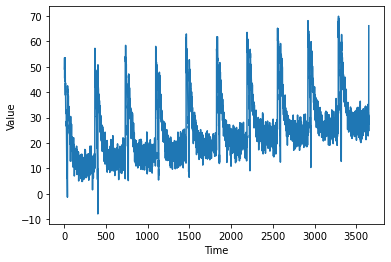

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                                                           input_shape=[None]),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
94/94 [==============================] - 10s 31ms/step - loss: 621.4111 - mae: 17.3184
Epoch 2/500
94/94 [==============================] - 3s 31ms/step - loss: 35.4449 - mae: 3.9949
Epoch 3/500
94/94 [==============================] - 3s 30ms/step - loss: 24.7060 - mae: 3.3967
Epoch 4/500
94/94 [==============================] - 3s 31ms/step - loss: 27.9481 - mae: 3.7105
Epoch 5/500
94/94 [==============================] - 3s 29ms/step - loss: 25.3553 - mae: 3.5254
Epoch 6/500
94/94 [==============================] - 3s 28ms/step - loss: 23.1941 - mae: 3.3501
Epoch 7/500
94/94 [==============================] - 3s 28ms/step - loss: 29.9593 - mae: 3.9666
Epoch 8/500
94/94 [==============================] - 3s 30ms/step - loss: 27.3687 - mae: 3.7184
Epoch 9/500
94/94 [==============================] - 3s 30ms/step - loss: 22.7929 - mae: 3.4158
Epoch 10/500
94/94 [==============================] - 3s 31ms/step - loss: 24.3466 - mae: 3.4988
Epoch 11/500
94/94 [================

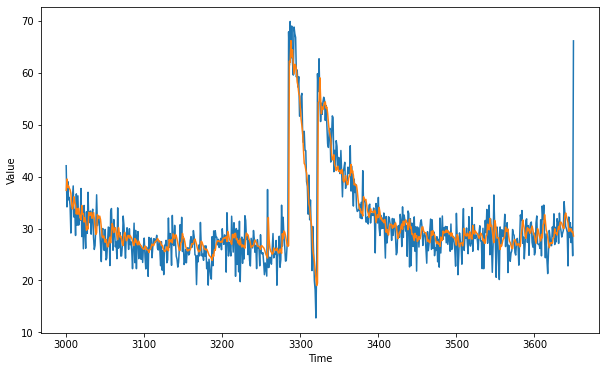

In [6]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [7]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.9205353